In [423]:
# Standard Math / Data libraries
import numpy as np
import pandas as pd

# Data Scrape Package
import pandas_datareader.data as web

# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/gru
import tensorflow as tf # version tensorflow==2.4.0
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras import layers

import yfinance as yf
yf.pdr_override()

In [424]:
# Daily Data on Gold.
tick = 'GOOG'
google = web.get_data_yahoo(tick,'2018-11-04')

[*********************100%%**********************]  1 of 1 completed


In [425]:
google.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-05,52.750000,52.923500,51.062000,52.004501,52.004501,48828000
2018-11-06,51.973999,53.217251,51.903500,52.790501,52.790501,24666000
2018-11-07,53.450001,54.772999,53.294998,54.669498,54.669498,41168000
2018-11-08,54.569000,54.663502,53.610249,54.119999,54.119999,29764000
2018-11-09,53.699501,53.778000,52.655499,53.307499,53.307499,26864000


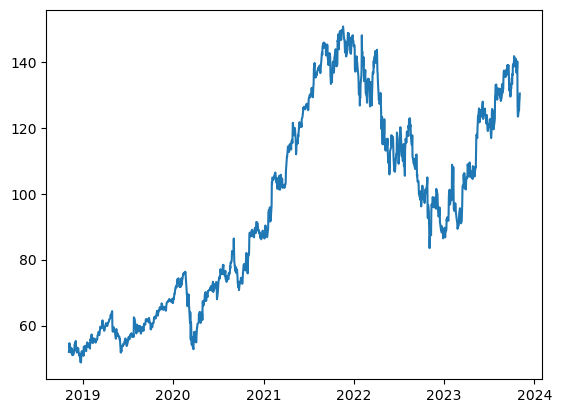

In [426]:
plt.plot(google['Adj Close'])


In [427]:
returns = google['Adj Close'].pct_change() # Used for univariate example.

column_names = google.columns
x = google.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [428]:
pct_c_google = df

In [429]:
pct_c_google.columns = column_names

In [430]:
pct_c_google.head()


,Open,High,Low,Close,Adj Close,Volume
0,0.039305,0.026947,0.025217,0.031340,0.031340,0.357428
1,0.031783,0.029829,0.033517,0.039054,0.039054,0.151275
2,0.046090,0.045093,0.047242,0.057494,0.057494,0.292072
3,0.056936,0.044019,0.050352,0.052101,0.052101,0.194772
4,0.048508,0.035331,0.040934,0.044127,0.044127,0.170028


# Predict future prices in GOOG (Multivariate Forecasting) using GRU

In [431]:
returns


Date
2018-11-05         NaN
2018-11-06    0.015114
2018-11-07    0.035593
2018-11-08   -0.010051
2018-11-09   -0.015013
                ...   
2023-10-30    0.019044
2023-10-31   -0.003579
2023-11-01    0.018116
2023-11-02    0.007917
2023-11-03    0.013921
Name: Adj Close, Length: 1258, dtype: float64

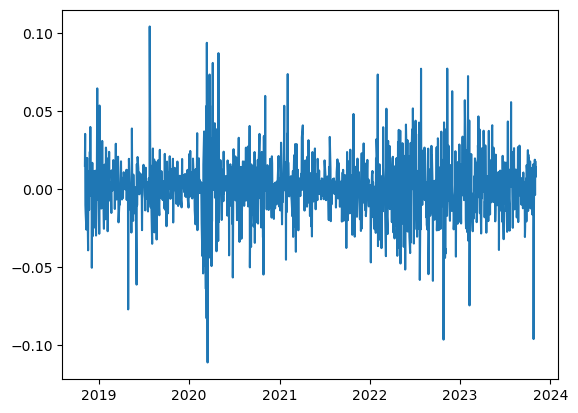

In [432]:
plt.plot(returns)


<Axes: >

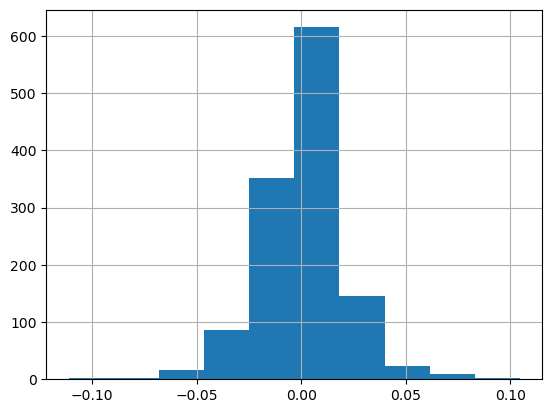

In [433]:
returns.hist()

In [434]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(pct_c_google.shape[0] - samples):
    X.append(pct_c_google.iloc[i:i+samples, 0:5].values) # Independent Samples
    Y.append(pct_c_google.iloc[i+samples, 5:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[0.03930464, 0.02694683, 0.0252165 , 0.03134017, 0.03134017],
       [0.03178295, 0.02982891, 0.03351679, 0.03905376, 0.03905376],
       [0.04608966, 0.04509287, 0.04724209, 0.05749375, 0.05749375],
       [0.05693599, 0.04401856, 0.05035162, 0.0521011 , 0.0521011 ],
       [0.04850804, 0.03533061, 0.04093427, 0.04412744, 0.04412744],
       [0.04240151, 0.02873739, 0.03002997, 0.03062375, 0.03062375],
       [0.03362947, 0.02603192, 0.03010395, 0.0293578 , 0.0293578 ],
       [0.03688142, 0.02503067, 0.03002997, 0.03309189, 0.03309189],
       [0.03431765, 0.03351059, 0.03041467, 0.04342087, 0.04342087],
       [0.04144193, 0.03113135, 0.03889744, 0.04184086, 0.04184086]])]
Testing Data: Length is  1 :  [array([0.25797754])]


In [435]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (1248, 10, 5) Dimensions of Y (1248, 1)


In [436]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

Training Length (1123, 10, 5) (1123, 1) Testing Length: (125, 10, 5) (125, 1)


In [437]:
# Let's build the GRU
model = keras.Sequential()

# Add a GRU layer with 15 units.
model.add(layers.GRU(15,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(X.shape[1], X.shape[2])))

# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 15)                990       
                                                                 
 dropout_24 (Dropout)        (None, 15)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 16        
                                                                 
Total params: 1006 (3.93 KB)
Trainable params: 1006 (3.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [438]:
# Fitting the data
history = model.fit(trainX,
                    trainY,
                    shuffle = False, # Since this is time series data
                    epochs=500,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/500
29/29 [==============================] - 1s 8ms/step - loss: 0.2077 - val_loss: 0.0266
Epoch 2/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0871 - val_loss: 0.0151
Epoch 3/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0725 - val_loss: 0.0102
Epoch 4/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0100
Epoch 5/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0090
Epoch 6/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0089
Epoch 7/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0088
Epoch 8/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0090
Epoch 9/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0088
Epoch 10/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0088
Epoch 11/

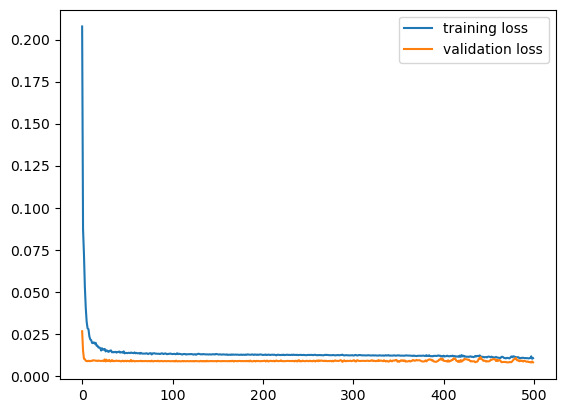

In [439]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

4/4 [==============================] - 0s 1ms/step


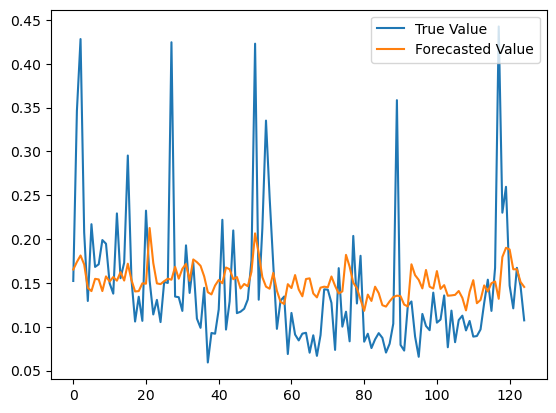

In [440]:
# This is a one step forecast (based on how we constructed our model)
y_pred = model.predict(testX)
plt.plot(testY, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()